<a href="https://colab.research.google.com/github/MatteoTomasetto/SHRED-ROM/blob/main/Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [150]:
# IMPORT LIBRARIES

import torch
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2025)

##**Drug Diffusion Model**

Consider a drug that is administered to a patient and diffuses between three compartments in the body, that are

1.   Blood (central compartment)
2.   Highly perfused tissues (like liver, kidneys)
3.   Poorly perfused tissues (like fat, muscle)


Let $u_1(t), u_2(t), u_3(t)$ be the amount of drug in each compartment at time $t$.

Let $k_{1 \to 2}, k_{2 \to 1}, k_{1 \to  3}, k_{3 \to 1}$ be the transfer rates between the compartments and let $k_{1 \to 0}$ be the elimination rate from the central compartment.

The system of ODEs describing the drug diffusion is

\
$$
\dot{{\bf u}} =
\begin{bmatrix}
-k_{1 \to 2}-k_{1 \to 3}-k_{1 \to 0}  & k_{2 \to 1} & k_{3 \to 1}
\\
k_{1 \to 2} & -k_{2 \to 1} & 0
\\
k_{1 \to 3} & 0 & -k_{3 \to 1}
\end{bmatrix}
{\bf u}
$$

\
where ${\bf u}(t) = [u_1(t), u_2(t), u_3(t)]^{\top}$.

Let us assume that $k_{1 \to 2} = 0.4$, $k_{2 \to 1} = 0.2$, $k_{1 \to 3} = 0.1$, $k_{3 \to 1} = 0.05$, while we consider a parametric elimination rate $k_{1 \to 0} = \mu$.


The explicit solution of the system is given by

\
$$
\begin{bmatrix}
u_1(t,\mu) \\ u_2(t,\mu) \\ u_3(t,\mu)
\end{bmatrix}
= \sum_{i=1}^3 c_i e^{\lambda_i(\mu) t} \mathbf{v}_i(\mu)
$$

\
where $\lambda_i(\mu)$ and $\mathbf{v}_i(\mu)$ for $i=1,2,3$ are, respectively, the eigenvalues and eigenvectors of the system matrix, while the coefficients $c_1, c_2, c_3$ has to be determined. To this aim, let us assume that a dose $D=1$ of the drug is administered to the central compartment at time $t=0$, that is $u_1(0, \mu) = 1, u_2(0, \mu) = u_3(0, \mu) = 0$. Therefore the coefficients $c_1,c_2,c_3$ are determined by the system

\
$$
\begin{bmatrix}
u_1(0,\mu) \\ u_2(0,\mu) \\ u_3(0,\mu)
\end{bmatrix}
=
\begin{bmatrix}
1 \\ 0 \\ 0
\end{bmatrix}
=
\begin{bmatrix}
| & | & | \\ \mathbf{v}_1(\mu) & \mathbf{v}_2(\mu) & \mathbf{v}_3(\mu) \\ | & | & |
\end{bmatrix}
\begin{bmatrix}
c_1 \\ c_2 \\ c_3
\end{bmatrix}
$$

In [151]:
# DEFINE THE SYSTEM SOLVER

def assembly(mu):
    '''
    Assembly the the three-Compartment drug diffusion model matrix

    Input
        parameter value   (`float`)

    Output
        system matrix     (`np.array[flaot]`, shape: (3, 3))
    '''

    # define transfer rates between compartments
    k12 = 0.4
    k21 = 0.2
    k13 = 0.1
    k31 = 0.05

    # define elimination rate from the central compartment
    k10 = mu

    # define the system matrix
    A = np.array([[-k12 -k13 -k10,  k21,  k31 ],
                  [ k12,           -k21,  0   ],
                  [ k13,            0,   -k31 ]])

    return A


def drug_diffusion(u0, mu, t):
    '''
    Solve the three-compartment drug diffusion model

    Inputs
        initial condition (`np.array[float]`, shape: (3,))
        parameter value   (`float`)
        time vector       (`np.array[float]`, shape: (ntimes,))

    Output
        solution matrix   (`np.array[float]`, shape: (ntimes, 3)
    '''

    u = np.zeros((len(t), len(u0)))   # solution vector
    u[0] = u0                         # initialization

    # assembly system matrix
    A = assembly(mu)

    # compute eigenvalues and eigenvectors of the system matrix
    lambdas, V = np.linalg.eig(A)

    # compute coefficients
    c = np.linalg.solve(V, u0)

    # compute solution
    for i in range(1,len(t)):
      u[i] = np.dot(V, c * np.exp(lambdas * t[i]))

    return u

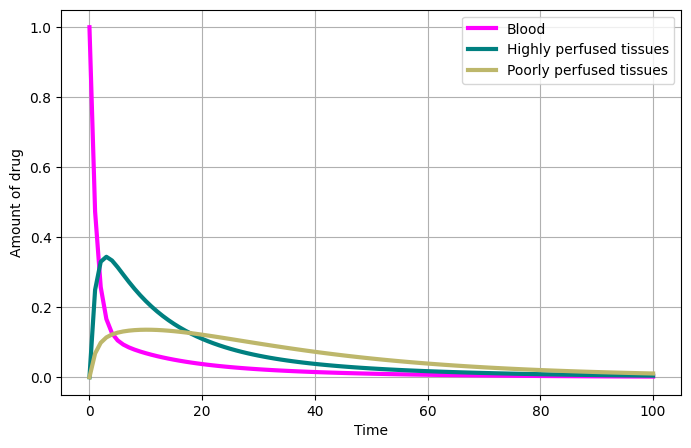

In [213]:
# SOLVE THE SYSTEM FOR A FIXED ELIMINATION RATE

D = 1.0   # initial dose
u0 = np.array([D, 0.0, 0.0])
nstate = len(u0)

mu = 0.3

dt = 1.0
T = 100.0
t = np.arange(0, T + dt, dt)
ntimes = len(t)

u = drug_diffusion(u0, mu, t)

plt.figure(figsize = (8,5))
plt.plot(t, u[:,0], color = 'magenta', linewidth = 3, label = 'Blood')
plt.plot(t, u[:,1], color = 'teal', linewidth = 3, label = 'Highly perfused tissues')
plt.plot(t, u[:,2], color = 'darkkhaki', linewidth = 3, label = 'Poorly perfused tissues')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amount of drug');
plt.grid(True)

In [216]:
# DATA GENERATION

D = 1.0   # initial dose
u0 = np.array([D, 0.0, 0.0])
nstate = len(u0)

mu_range = [0.0, 1.0]

dt = 1.0
T = 100.0
t = np.arange(0, T + dt, dt)
ntimes = len(t)

# training data generation
ntrajectories = 20
U = np.zeros((ntrajectories, ntimes, nstate))
mus = np.linspace(mu_range[0], mu_range[1], ntrajectories)

for i in range(ntrajectories):
  U[i] = drug_diffusion(u0, mus[i], t)

# test data generation
ntest = 100
Utest = np.zeros((ntest, ntimes, nstate))
for i in range(ntest):
  mus_test = (mu_range[1] - mu_range[0]) * np.random.rand() + mu_range[0]
  Utest[i] = drug_diffusion(u0, mus_test, t)

In [217]:
# DATA VISUALIZATION

from ipywidgets import interact, FloatSlider

def plot_data(param):

    plt.figure(figsize = (8,5))
    idx = (np.abs(mus - param)).argmin()
    plt.plot(t, U[idx,:,0], color = 'magenta', linewidth = 3, label = 'Blood')
    plt.plot(t, U[idx,:,1], color = 'teal', linewidth = 3, label = 'Highly perfused tissues')
    plt.plot(t, U[idx,:,2], color = 'darkkhaki', linewidth = 3, label = 'Poorly perfused tissues')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Amount of drug');
    plt.title(f'Elimination rate {round(param,3)}');
    plt.grid(True)

interact(plot_data, param = FloatSlider(value = mus[0], min = mus[0], max = mus[-1], step = (mus[1]-mus[0]), description='μ', layout={'width': '550px', 'height': '50px'}));

interactive(children=(FloatSlider(value=0.0, description='μ', layout=Layout(height='50px', width='550px'), max…

In [218]:
# TORCH CONVERSION

U = torch.from_numpy(U)
Utest = torch.from_numpy(Utest)

In [219]:
# TRAIN-VALIDATION SPLITTING

split_ratio = 0.8

ntrain = round(split_ratio * ntrajectories)

idx_train = np.random.choice(ntrajectories, size = ntrain, replace = False)
mask = np.ones(ntrajectories)
mask[idx_train] = 0
idx_valid = np.arange(0, ntrajectories)[np.where(mask!=0)[0]]

nvalid = idx_valid.shape[0]

Utrain = U[idx_train]
Uvalid = U[idx_valid]

## **SHallow REcurrent Decoder networks-based Reduced Order Modeling (SHRED-ROM)**

Let us assume to have a sensor in the blood measuring the drug amount $u_1$ over time. *SHRED-ROM* aims to reconstruct the temporal evolution of the entire state vector $\mathbf{u}(t\mu)$ starting from the limited sensor measurements available. In general, *SHRED-ROM* combines a recurrent neural network (LSTM), which encodes the temporal history of sensor values in multiple parametric regimes, and a shallow decoder, which projects the LSTM prediction to the (possibly high-dimensional) state dimension. Note that, in the example at hand, the state dimension is equal to $3$ and the decoder is not stricly needed.  

\
## Is the sensor-to-state reconstruction feasible?

The coefficients $c_1, c_2, c_3$ in the explicit solution formula may be determined by employing one sensor monitoring $u_1$ over time. Specifically, if we measure $u_1(0,\mu), u_1(1,\mu), u_1(2\mu)$ in the scenario identified by $\mu$, the linear system

\
$$
\begin{bmatrix}
u_1(0,\mu) \\ u_1(1,\mu) \\ u_1(2,\mu)
\end{bmatrix}  
= \begin{bmatrix}
\mathbf{v}_1(\mu)[0] & \mathbf{v}_2(\mu)[0] & \mathbf{v}_3(\mu)[0]
\\
e^{\lambda_1(\mu)} \mathbf{v}_1(\mu)[0] & e^{\lambda_2(\mu)}\mathbf{v}_2(\mu)[0] & e^{\lambda_3(\mu)}\mathbf{v}_3(\mu)[0]
\\
e^{2\lambda_1(\mu)}\mathbf{v}_1(\mu)[0] & e^{2\lambda_2(\mu)}\mathbf{v}_2(\mu)[0] & e^{2\lambda_3(\mu)}\mathbf{v}_3(\mu)[0]
\end{bmatrix}
\begin{bmatrix}
c_1 \\ c_2 \\ c_3
\end{bmatrix}
$$

\
returns$^\ast$ the coefficients $c_1, c_2, c_3$ and, thus, allows us to compute the evolution of the state vector $\mathbf{u}$.

\
$\ast$ The linear system in the unknowns $c_1, c_2, c_3$ is well-posed only if the dynamical system is observable with respect to the sensor measurments, i.e. if the observability matrix

\
$$
O = \begin{bmatrix}
C \\ C A \\ C A^2
\end{bmatrix}
$$

\
is full-rank, where $C$ is the output matrix ($C = [1,0,0]$ in the example at hand since we measure the first state component) and $A$ is the dynamical system matrix.

In [220]:
# CHECK OBSERVABILITY

mu = 0.3
A = assembly(mu)

C = [1, 0, 0]
O = np.array([C, np.dot(C, A), np.dot(C, A*A)])
if np.linalg.matrix_rank(O) == nstate:
    print('The system is observable')
else:
    print('The system is not observable')

The system is observable


In [221]:
# DEFINE FUNCTION TO PROCESS DATA

class TimeSeriesDataset(torch.utils.data.Dataset):
    '''
    Define a dataset of input-output time-series

    Inputs
        sequence of input measurements    (`torch.Tensor[float]`, shape: (ntrajectories, ntimes, ninput))
        state measurements                (`torch.Tensor[float]`, shape: (ntrajectories, ntimes, noutput))

    Output
        Torch dataset                     (`torch.utils.data.Dataset`)
    '''

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.len = X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

    def __len__(self):
        return self.len


def Padding(data, lag):
    '''
    Extract time-series of lenght equal to lag from longer time series in data

    Inputs
        time-series data          (`torch.Tensor[float]`, shape: (ntrajectories, ntimes, ninput))
        lag parameter             (`int`)

    Input
        lagged time-series data   (`torch.Tensor[float]`, shape: (ntrajectories * ntimes, lag, ninput))
    '''

    data_out = torch.zeros(data.shape[0] * data.shape[1], lag, data.shape[2])

    for i in range(data.shape[0]):
        for j in range(1, data.shape[1] + 1):
            if j < lag:
                data_out[i * data.shape[1] + j - 1, -j:] = data[i, :j]
            else:
                data_out[i * data.shape[1] + j - 1] = data[i, j - lag : j]

    return data_out

In [222]:
# DEFINE SHRED MODEL

class SHRED(torch.nn.Module):

    def __init__(self, input_size, output_size, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.0):
        '''
        SHRED model definition

        Inputs
        	input size (e.g. number of sensors)                 (`int`)
        	output size (e.g. full-order variable dimension)    (`int`)
        	size of LSTM hidden layers                          (`int`)
        	number of LSTM hidden layers                        (`int`)
        	list of decoder layers sizes                        (`list[int]`)
        	dropout parameter                                   (`float`)
        '''

        super(SHRED,self).__init__()

        self.lstm = torch.nn.LSTM(input_size = input_size,
                                  hidden_size = hidden_size,
                                  num_layers = hidden_layers,
                                  batch_first=True)

        self.decoder = torch.nn.ModuleList()
        decoder_sizes.insert(0, hidden_size)
        decoder_sizes.append(output_size)

        for i in range(len(decoder_sizes)-1):
            self.decoder.append(torch.nn.Linear(decoder_sizes[i], decoder_sizes[i+1]))
            if i != len(decoder_sizes)-2:
                self.decoder.append(torch.nn.Dropout(dropout))
                self.decoder.append(torch.nn.ReLU())

        self.hidden_layers = hidden_layers
        self.hidden_size = hidden_size

    def forward(self, x):

        h_0 = torch.zeros((self.hidden_layers, x.size(0), self.hidden_size), dtype=torch.float)
        c_0 = torch.zeros((self.hidden_layers, x.size(0), self.hidden_size), dtype=torch.float)
        if next(self.parameters()).is_cuda:
            h_0 = h_0.cuda()
            c_0 = c_0.cuda()

        _, (output, _) = self.lstm(x, (h_0, c_0))
        output = output[-1].view(-1, self.hidden_size)

        for layer in self.decoder:
            output = layer(output)

        return output

    def freeze(self):

        self.eval()

        for param in self.parameters():
            param.requires_grad = False

    def unfreeze(self):

        self.train()

        for param in self.parameters():
            param.requires_grad = True


In [223]:
# DEFINE TRAINING FUNCTION

from torch.utils.data import DataLoader
from copy import deepcopy
from IPython.display import clear_output as clc

mse = lambda datatrue, datapred: (datatrue - datapred).pow(2).sum(axis = -1).mean()  # Mean Squared Error
error_formatter = lambda error: ".6f" % error

def fit(model, train_dataset, valid_dataset, batch_size = 64, epochs = 4000, optim = torch.optim.Adam, lr = 1e-3, loss_fun = mse, loss_output = mse, formatter = error_formatter, verbose = False, patience = 5):
    '''
    Neural networks training

    Inputs
    	model                                 (`torch.nn.Module`)
    	training dataset                      (`torch.Tensor`)
    	validation dataset                    (`torch.Tensor`)
    	batch size                            (`int`)
    	number of epochs                      (`int`)
    	optimizer                             (`function`)
    	learning rate                         (`float`)
      loss function                         (`function`)
      loss value to print and return        (`function`)
      loss formatter for printing           (`function`)
    	verbose parameter                     (`bool`)
    	patience parameter                    (`int`)
    '''

    train_loader = DataLoader(train_dataset, shuffle = True, batch_size = batch_size)
    optimizer = optim(model.parameters(), lr = lr)

    train_error_list = []
    valid_error_list = []
    patience_counter = 0
    best_params = model.state_dict()

    for epoch in range(1, epochs + 1):

        for k, data in enumerate(train_loader):
            model.train()
            def closure():
                outputs = model(data[0])
                optimizer.zero_grad()
                loss = loss_fun(outputs, data[1])
                loss.backward()
                return loss
            optimizer.step(closure)

        model.eval()
        with torch.no_grad():
            train_error = loss_output(train_dataset.Y, model(train_dataset.X))
            valid_error = loss_output(valid_dataset.Y, model(valid_dataset.X))
            train_error_list.append(train_error)
            valid_error_list.append(valid_error)

        if verbose == True:
            print("Epoch "+ str(epoch) + ": Training loss = " + "%.6f" % train_error_list[-1] + " \t Validation loss = " + "%.6f" % valid_error_list[-1])
            clc(wait = True)

        if valid_error == torch.min(torch.tensor(valid_error_list)):
            patience_counter = 0
            best_params = deepcopy(model.state_dict())
        else:
            patience_counter += 1

        if patience_counter == patience:
            model.load_state_dict(best_params)
            train_error = loss_output(train_dataset.Y, model(train_dataset.X))
            valid_error = loss_output(valid_dataset.Y, model(valid_dataset.X))

            if verbose == True:
                print("Training done: Training loss = " + "%.6f" % train_error + " \t Validation loss = " + "%.6f" % valid_error)

            return torch.tensor(train_error_list).detach().cpu().numpy(), torch.tensor(valid_error_list).detach().cpu().numpy()

    model.load_state_dict(best_params)
    train_error = loss_output(train_dataset.Y, model(train_dataset.X))
    valid_error = loss_output(valid_dataset.Y, model(valid_dataset.X))

    if verbose == True:
      print("Training done: Training loss = " + "%.6f" % train_error + " \t Validation loss = " + "%.6f" % valid_error)

    return torch.tensor(train_error_list).detach().cpu().numpy(), torch.tensor(valid_error_list).detach().cpu().numpy()

In [224]:
# EXTRACT SENSORS DATA

idx_sensor = 0
nsensors = 1

sensors_data_train = Utrain[:,:,idx_sensor]
sensors_data_valid = Uvalid[:,:,idx_sensor]
sensors_data_test = Utest[:,:,idx_sensor]

In [225]:
# BUILD TRAIN, VALIDATION AND TEST DATASETS WITH PADDING

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lag = 25

train_data_in = Padding(sensors_data_train.unsqueeze(2), lag).to(device)
valid_data_in = Padding(sensors_data_valid.unsqueeze(2), lag).to(device)
test_data_in = Padding(sensors_data_test.unsqueeze(2), lag).to(device)

train_data_out = Padding(Utrain, 1).squeeze(1).to(device)
valid_data_out = Padding(Uvalid, 1).squeeze(1).to(device)
test_data_out = Padding(Utest, 1).squeeze(1).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

In [226]:
# SHRED TRAINING

shred = SHRED(nsensors, nstate, hidden_size = 64, hidden_layers = 2, decoder_sizes = [], dropout = 0.1).to(device)
train_errors, valid_errors = fit(shred, train_dataset, valid_dataset, batch_size = 64, epochs = 150, lr = 1e-3, verbose = True, patience = 100)

Training done: Training loss = 0.000015 	 Validation loss = 0.000013


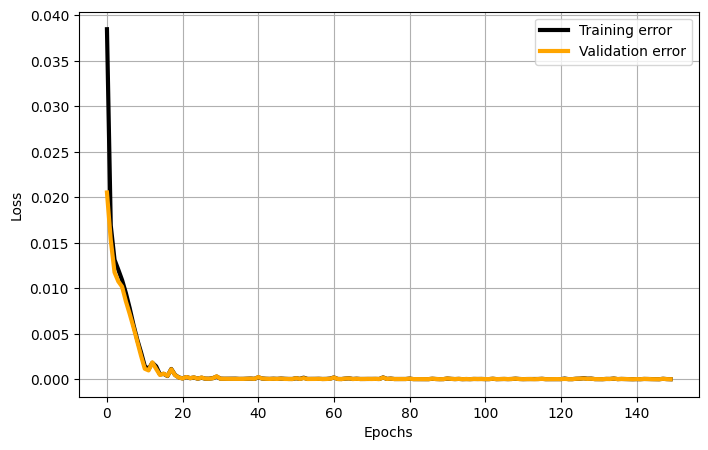

In [227]:
# TRAINING HISTORY VISUALIZATION

plt.figure(figsize = (8,5))
plt.plot(train_errors, 'k', linewidth = 3, label = 'Training error')
plt.plot(valid_errors, 'orange', linewidth = 3, label = 'Validation error')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

In [228]:
# SHRED RECONSTRUCTION VISUALIZATION

from ipywidgets import interact, IntSlider
import matplotlib.lines as mlines

shred.freeze()

Utest_hat = shred(test_data_in).cpu().reshape(ntest, ntimes, nstate)

def plot_shred_reconstruction(which_test_trajectory):

    plt.figure(figsize = (8,5))
    plt.plot(t, Utest[which_test_trajectory,:,0], color = 'magenta', linewidth = 1, label = 'Blood')
    plt.plot(t, Utest[which_test_trajectory,:,1], color = 'teal', linewidth = 1, label = 'Highly perfused tissues')
    plt.plot(t, Utest[which_test_trajectory,:,2], color = 'darkkhaki', linewidth = 1, label = 'Poorly perfused tissues')
    plt.plot(t, Utest_hat[which_test_trajectory,:,0], color = 'magenta', linestyle = '--', linewidth = 3, label = r'$u_1$ reconstruction')
    plt.plot(t, Utest_hat[which_test_trajectory,:,1], color = 'teal', linestyle = '--', linewidth = 3, label = r'$u_2$ reconstruction')
    plt.plot(t, Utest_hat[which_test_trajectory,:,2], color = 'darkkhaki', linestyle = '--', linewidth = 3, label = r'$u_3$ reconstruction')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Amount of drug');
    plt.title(f'Test case {which_test_trajectory}');
    plt.grid(True)

interact(plot_shred_reconstruction, which_test_trajectory = IntSlider(value = 0, min = 0, max = ntest - 1, description='Test case', layout={'width': '550px', 'height': '50px'}));

interactive(children=(IntSlider(value=0, description='Test case', layout=Layout(height='50px', width='550px'),…